# Ajuste de una recta con emcee

Seguimos el ejemplo mostrado en http://dfm.io/emcee/current/user/line/ para ajustar una recta a un conjunto de datos cuando no confiamos en las barras de error de éstos.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from pylab import rcParams
import emcee
import corner

rcParams['figure.figsize'] = (10, 6)

## El modelo generativo probabilístico

Primero, supongamos un modelo lineal $ y = mx + b $ donde las incertidumbres son subestimadas por una cantidad constante y fraccionaria $f$.

In [3]:
# Estos son los parámetros 'verdaderos'
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generamos datos sintéticos para ajustarlos
N = 50
x = np.sort(10 * np.random.rand(N))
yerror = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerror * np.random.randn(N)

La siguiente gráfica muestra los datos a ajustar junto con sus barras de error. La recta gris es el modelo real al que debería aproximarse nuestro ajuste.

<ErrorbarContainer object of 3 artists>

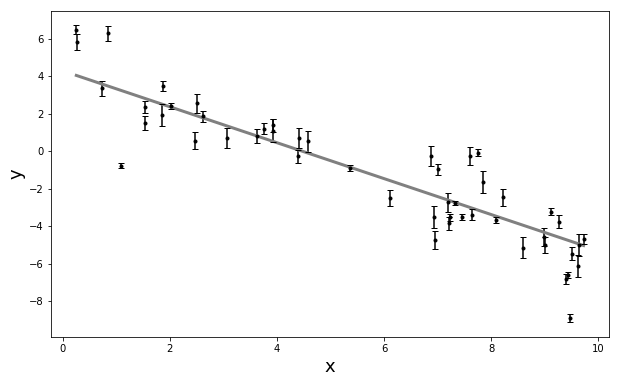

In [4]:
fig, ax = plt.subplots(figsize = (10, 6))

def true_model(x):
    return m_true * x + b_true

true_vect = np.vectorize(true_model)

plt.plot(x, true_vect(x), color = 'gray', linewidth = 3)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
ax.errorbar(x, y, yerr = yerror, fmt = 'o', ms = 3, ecolor = 'black',
            color = 'black', capsize = 3, capthick = 1)

Se observa la subestimación de las barras de error. Un ajuste por mínimos cuadrados arroja el siguiente resultado, el cual aparece en la gráfica como una línea punteada negra:

In [5]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerror * yerror)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

print 'm =', m_ls, 'b =', b_ls

m = -0.9319286608127548 b = 3.762822178834572


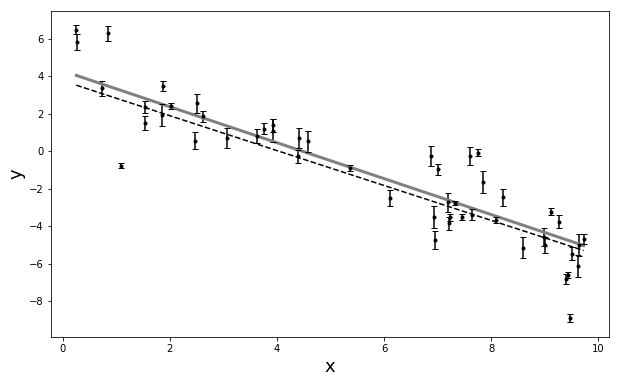

In [6]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(x, true_vect(x), color = 'gray', linewidth = 3)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
ax.errorbar(x, y, yerr = yerror, fmt = 'o', ms = 3, ecolor = 'black',
            color = 'black', capsize = 3, capthick = 1)

def lls_model(x):
    return m_ls * x + b_ls

lls_vect = np.vectorize(lls_model)

plt.plot(x, lls_vect(x), '--', color = 'black')

## Estimación por maximización del likelihood

No hay una generalización del método de mínimos cuadrados que pueda utilizarse cuando las barras de error no son gaussianas, correctas o independientes. En su lugar, necesitamos escribir la función de likelihood y optimizarla numéricamente:

$$
\ln p(y|x, \sigma, m, b, f) = -\frac{1}{2} \sum_n \left[ \frac{(y_n - mx_n -b)^2}{s_n^2} + \ln(2\pi s_n^2) \right]
$$

donde

$$
s_n^2 = \sigma_n^2 + f^2(mx_n + b)^2
$$

Esta función es simplemente una gaussiana donde la varianza ha sido subestimada por una factor $f$.

El resultado de este ajuste se muestra en la gráfica con una línea sólida negra.

In [7]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args = (x, y, yerror))
m_ml, b_ml, lnf_ml = result["x"]

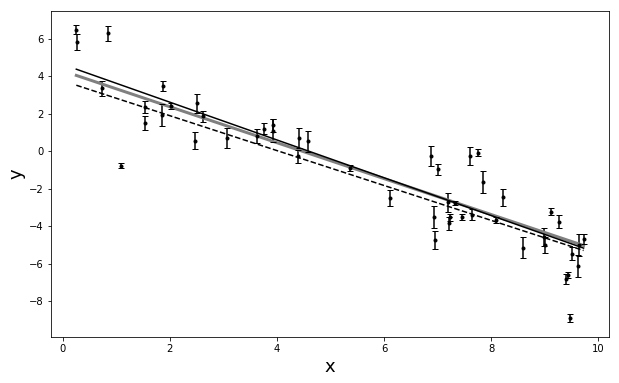

In [8]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(x, true_vect(x), color = 'gray', linewidth = 3)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
ax.errorbar(x, y, yerr = yerror, fmt = 'o', ms = 3, ecolor = 'black',
            color = 'black', capsize = 3, capthick = 1)
plt.plot(x, lls_vect(x), '--', color = 'black')

def maxlike_model(x):
    return m_ml * x + b_ml

ml_vect = np.vectorize(maxlike_model)

plt.plot(x, ml_vect(x), color = 'black')

Los valores encontrados para esta optimización son:

In [9]:
print 'm =', m_ml, 'b =', b_ml, 'lnf =', lnf_ml

m = -1.0090307020043074 b = 4.6383717349157765 lnf = -0.7751149080120217


## Marginalización y estimación de incertidumbres

¿Cómo calculamos las incertidumbres en $m$ y $b$? Con MCMC.

Comencemos definiendo el posterior, tal como lo vimos en el ejericicio del teorema de Bayes:

$$
p(m, b, f|x, y, \sigma) \propto p(m, b, f)p(y|x, \sigma, m, b, f)
$$

Supondremos priors uniformes. Por ejemplo, para $m$:

$$
p(m) = \left\{
        \begin{array}{ll}
            1/5.5 & -5 < m < 1/2 \\
            0 & \quad m \leq -5, m \geq 1/2
        \end{array}
    \right.
$$

In [10]:
# Esta función es el logaritmo del prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [11]:
# Esta función combina el logaritmo del prior con
# la definición de lnlike de arriba para formar
# la función completa log-probability
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerror)

Ahora ya podemos muestrear nuestra distribución usando emcee. Comenzaremos inicializando los caminadores en una pequeña bola gaussiana alrededor del resultado que ya encontramos para el máximo likelihood:

In [12]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

Preparamos el muestreador:

In [13]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerror))

Y corremos MCMC con $500$ pasos.

In [14]:
N_steps = 500
sampler.run_mcmc(pos, N_steps);

Las siguientes gráficas (_cola de gato_) muestran los valores de cada caminador en cada paso para cada parámetro. Las líneas grises señalan el valor real de los parámetros.

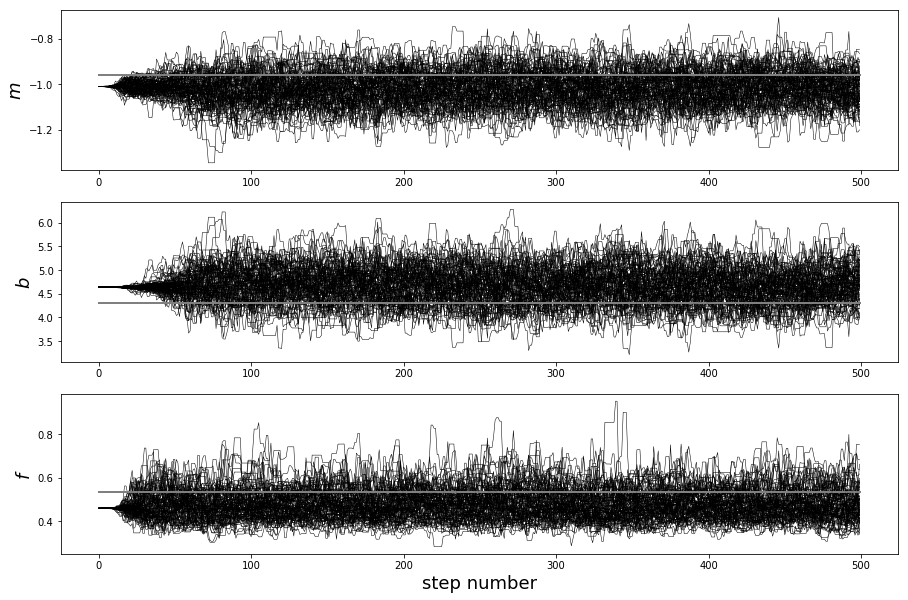

In [27]:
pasos = np.arange(N_steps)
m_line = m_true * np.ones(500)
b_line = b_true * np.ones(500)
f_line = f_true * np.ones(500)
plt.figure(figsize = (15,10))

for i in range(nwalkers):
    plt.subplot(3, 1, 1)
    plt.plot(pasos, sampler.chain[i,:,0], color = 'black', linewidth = 0.5)
    plt.plot(m_line, color = 'gray')
    plt.ylabel('$m$', fontsize = 18)

    plt.subplot(3, 1, 2)
    plt.plot(pasos, sampler.chain[i,:,1], color = 'black', linewidth = 0.5)
    plt.plot(b_line, color = 'gray')
    plt.ylabel('$b$', fontsize = 18)

    plt.subplot(3, 1, 3)
    plt.plot(pasos, np.exp(sampler.chain[i,:,2]), color = 'black', linewidth = 0.5)
    plt.plot(f_line, color = 'gray')
    plt.ylabel('$f$', fontsize = 18)
    plt.xlabel('step number',fontsize = 18)

Ignoremos los primeros cincuenta pasos de la muestra:

In [25]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Resultados

Es fácil visualizar los resultados utilizando la llamada _gráfica de esquina_ (o de aguacates). Esta gráfica muestra las distribuciones marginalizadas de cada parámetro de manera independiente en los histogramas a lo largo de la diagonal, y las distribuciones marginalizadas dos-dimensionales en el resto de los paneles.

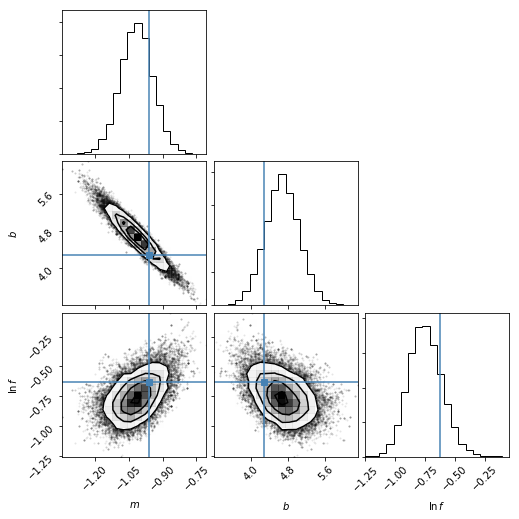

In [31]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

Otra gráfica útil es la de la proyección de los resultados en el espacio de los datos observavdos. Para esto, podemos elegir unas pocas muestras de la cadena y graficarlas encima de los datos.

<ErrorbarContainer object of 3 artists>

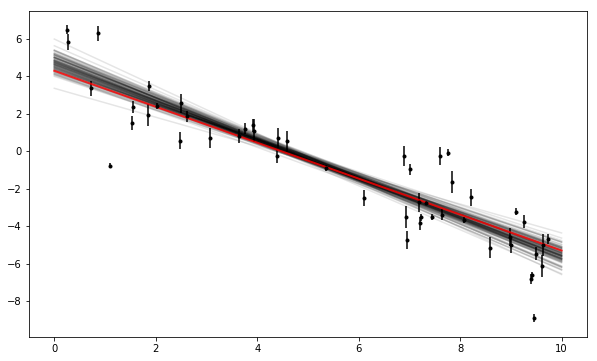

In [33]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size = 100)]:
    plt.plot(xl, m * xl + b, color = "k", alpha = 0.1)
plt.plot(xl, m_true * xl + b_true, color = "r", lw = 2, alpha = 0.8)
plt.errorbar(x, y, yerr = yerror, fmt = ".k")

Ahora sí, las incetidumbres que quedamos a deber. Éstas pueden elegirse de varias maneras. La que usa el autor del tutorial consiste en tomar los percentiles número $16$, $50$ y $84$ de las muestras en las distribuciones marginalizadas. Para calcular estos números, se usa el siguiente código:

In [34]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

Ya solo falta averiguar cómo se imprimen...